All libraries imported successfully.
Full dataset shape: (284807, 30), Frauds: 492, Non-frauds: 284315
Original train shape: (227845, 30), Frauds: 394, Non-frauds: 227451
Original test shape: (56962, 30), Frauds: 98, Non-frauds: 56864
After outlier removal: (225566, 30), Frauds: 156, Non-frauds: 225410
After removing NaN: (225566, 30), Frauds: 156, Non-frauds: 225410
Scaled training data shape: (225566, 30)
After SMOTEENN: (450401, 30), Frauds: 225410, Non-frauds: 224991
Final balanced training feature shape (PCA+KBest): (450401, 25)
Test feature shape (PCA+KBest): (56962, 25)
PyTorch MLP model initialized.
Starting training...
Epoch 1/10, Loss: 0.0464
Epoch 2/10, Loss: 0.0077
Epoch 3/10, Loss: 0.0051
Epoch 4/10, Loss: 0.0040
Epoch 5/10, Loss: 0.0036
Epoch 6/10, Loss: 0.0031
Epoch 7/10, Loss: 0.0026
Epoch 8/10, Loss: 0.0025
Epoch 9/10, Loss: 0.0021
Epoch 10/10, Loss: 0.0022
Training complete.

Evaluation on Original Test Set (Imbalanced):
              precision    recall  f1-score   s

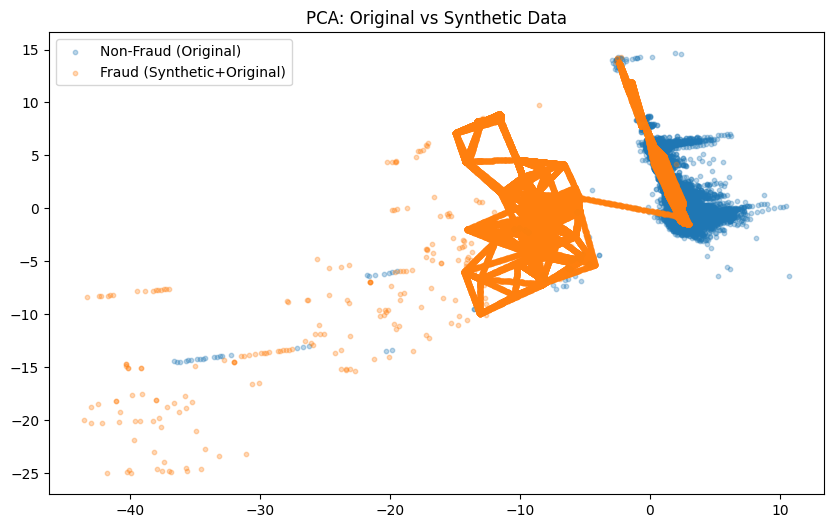

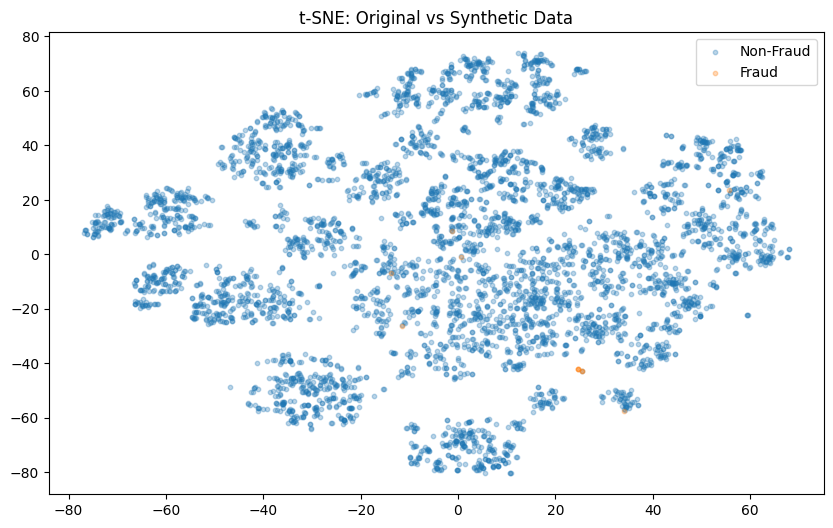

Visualization complete.


In [2]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

print("All libraries imported successfully.")

# 1. Load data and split into train/test
df = pd.read_csv("creditcard.csv")
X = df.drop("Class", axis=1)
y = df["Class"]
print(f"Full dataset shape: {X.shape}, Frauds: {y.sum()}, Non-frauds: {len(y)-y.sum()}")

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Original train shape: {X_train_orig.shape}, Frauds: {y_train_orig.sum()}, Non-frauds: {len(y_train_orig)-y_train_orig.sum()}")
print(f"Original test shape: {X_test_orig.shape}, Frauds: {y_test_orig.sum()}, Non-frauds: {len(y_test_orig)-y_test_orig.sum()}")

# 2. Preprocess training data
# Outlier removal
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_train_orig)
mask = outliers != -1
X_train_filt = X_train_orig[mask]
y_train_filt = y_train_orig[mask]
print(f"After outlier removal: {X_train_filt.shape}, Frauds: {y_train_filt.sum()}, Non-frauds: {len(y_train_filt)-y_train_filt.sum()}")

# Remove NaN in target
X_train_filt = X_train_filt.loc[~y_train_filt.isna()]
y_train_filt = y_train_filt.dropna()
print(f"After removing NaN: {X_train_filt.shape}, Frauds: {y_train_filt.sum()}, Non-frauds: {len(y_train_filt)-y_train_filt.sum()}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filt)
print(f"Scaled training data shape: {X_train_scaled.shape}")

# Class balancing
smote_enn = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = smote_enn.fit_resample(X_train_scaled, y_train_filt)
print(f"After SMOTEENN: {X_train_bal.shape}, Frauds: {sum(y_train_bal==1)}, Non-frauds: {sum(y_train_bal==0)}")

# Feature selection
pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_bal)
X_train_pca = pca.transform(X_train_bal)
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train_bal, y_train_bal)
X_train_kbest = selector.transform(X_train_bal)
X_train_final = np.hstack((X_train_pca, X_train_kbest))
print(f"Final balanced training feature shape (PCA+KBest): {X_train_final.shape}")

# 3. Prepare test data (no balancing)
X_test_scaled = scaler.transform(X_test_orig)
X_test_pca = pca.transform(X_test_scaled)
X_test_kbest = selector.transform(X_test_scaled)
X_test_final = np.hstack((X_test_pca, X_test_kbest))
print(f"Test feature shape (PCA+KBest): {X_test_final.shape}")

# 4. Define PyTorch model
class FraudMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FraudMLP(input_dim=X_train_final.shape[1]).to(device)
print("PyTorch MLP model initialized.")

# 5. Train model
train_dataset = TensorDataset(
    torch.tensor(X_train_final, dtype=torch.float32),
    torch.tensor(y_train_bal.values, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

print("Starting training...")
model.train()
for epoch in range(10):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10, Loss: {total_loss/len(train_loader):.4f}")
print("Training complete.")

# 6. Evaluate on original test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)
    y_pred = model(X_test_tensor).cpu().numpy()

print("\nEvaluation on Original Test Set (Imbalanced):")
print(classification_report(y_test_orig, (y_pred > 0.5).astype(int)))
precision, recall, _ = precision_recall_curve(y_test_orig, y_pred)
print(f"PR-AUC: {auc(recall, precision):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_orig, y_pred):.4f}")

# 7. Sanity check with logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_final, y_train_bal)
y_pred_lr = lr.predict_proba(X_test_final)[:, 1]

print("\nLogistic Regression Results (on original test set):")
print(classification_report(y_test_orig, (y_pred_lr > 0.5).astype(int)))
print(f"LR ROC-AUC: {roc_auc_score(y_test_orig, y_pred_lr):.4f}")

# 8. Visualize synthetic vs original data
print("Visualizing data with PCA and t-SNE...")
X_original_scaled = scaler.transform(X_train_orig)
X_combined = np.vstack([X_original_scaled, X_train_bal])
y_combined = np.hstack([y_train_orig, y_train_bal])

# PCA
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X_combined)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca_vis[y_combined == 0, 0], X_pca_vis[y_combined == 0, 1], 
            label="Non-Fraud (Original)", alpha=0.3, s=10)
plt.scatter(X_pca_vis[y_combined == 1, 0], X_pca_vis[y_combined == 1, 1], 
            label="Fraud (Synthetic+Original)", alpha=0.3, s=10)
plt.title("PCA: Original vs Synthetic Data")
plt.legend()
plt.show()

# t-SNE (subsample for speed)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_combined[:5000])
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[y_combined[:5000] == 0, 0], X_tsne[y_combined[:5000] == 0, 1], 
            label="Non-Fraud", alpha=0.3, s=10)
plt.scatter(X_tsne[y_combined[:5000] == 1, 0], X_tsne[y_combined[:5000] == 1, 1], 
            label="Fraud", alpha=0.3, s=10)
plt.title("t-SNE: Original vs Synthetic Data")
plt.legend()
plt.show()
print("Visualization complete.")

In [3]:
# Improvements: RandomForest+MLP ensemble, MLP hyperparameter tuning, threshold tuning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, classification_report
import numpy as np

print("Starting improvements: RandomForest ensemble, MLP hyperparameter tuning, threshold tuning.")

# 1. Train RandomForest on balanced training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train_bal)
print("RandomForest trained.")

# 2. Hyperparameter tuning for MLP (grid search on learning rate and epochs)
param_grid = {
    'lr': [1e-3, 5e-4],
    'epochs': [10, 15]
}

best_f1 = 0
best_params = {}
best_model = None

for params in ParameterGrid(param_grid):
    model = FraudMLP(input_dim=X_train_final.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    criterion = nn.BCELoss()
    model.train()
    train_dataset = TensorDataset(
        torch.tensor(X_train_final, dtype=torch.float32),
        torch.tensor(y_train_bal.values, dtype=torch.float32)
    )
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    
    for epoch in range(params['epochs']):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    # Evaluate on original test set
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy()
    y_pred_bin = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_test_orig, y_pred_bin)
    print(f"MLP Params: {params}, F1-score: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model

print(f"Best MLP params: {best_params}, Best F1: {best_f1:.4f}")

# 3. Ensemble predictions (average probabilities) on test set
rf_pred_proba = rf.predict_proba(X_test_final)[:, 1]
mlp_pred_proba = best_model(torch.tensor(X_test_final, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
ensemble_pred_proba = (rf_pred_proba + mlp_pred_proba) / 2

# 4. Threshold tuning to maximize F1-score
thresholds = np.linspace(0.1, 0.9, 81)
best_threshold = 0.5
best_f1_thresh = 0
for thresh in thresholds:
    pred_bin = (ensemble_pred_proba > thresh).astype(int)
    f1 = f1_score(y_test_orig, pred_bin)
    if f1 > best_f1_thresh:
        best_f1_thresh = f1
        best_threshold = thresh

print(f"Best threshold for ensemble: {best_threshold:.2f}, F1-score: {best_f1_thresh:.4f}")

# 5. Final classification report with best threshold
final_pred_bin = (ensemble_pred_proba > best_threshold).astype(int)
print("\nEnsemble Classification Report with Threshold Tuning:")
print(classification_report(y_test_orig, final_pred_bin))

print("\nImprovements added: RandomForest ensemble, MLP hyperparameter tuning, threshold tuning for better precision-recall tradeoff.")


Starting improvements: RandomForest ensemble, MLP hyperparameter tuning, threshold tuning.
RandomForest trained.
MLP Params: {'epochs': 10, 'lr': 0.001}, F1-score: 0.5862
MLP Params: {'epochs': 10, 'lr': 0.0005}, F1-score: 0.6466
MLP Params: {'epochs': 15, 'lr': 0.001}, F1-score: 0.6308
MLP Params: {'epochs': 15, 'lr': 0.0005}, F1-score: 0.5959
Best MLP params: {'epochs': 10, 'lr': 0.0005}, Best F1: 0.6466
Best threshold for ensemble: 0.75, F1-score: 0.7707

Ensemble Classification Report with Threshold Tuning:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.74      0.81      0.77        98

    accuracy                           1.00     56962
   macro avg       0.87      0.90      0.89     56962
weighted avg       1.00      1.00      1.00     56962


Improvements added: RandomForest ensemble, MLP hyperparameter tuning, threshold tuning for better precision-recall tradeoff.


c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


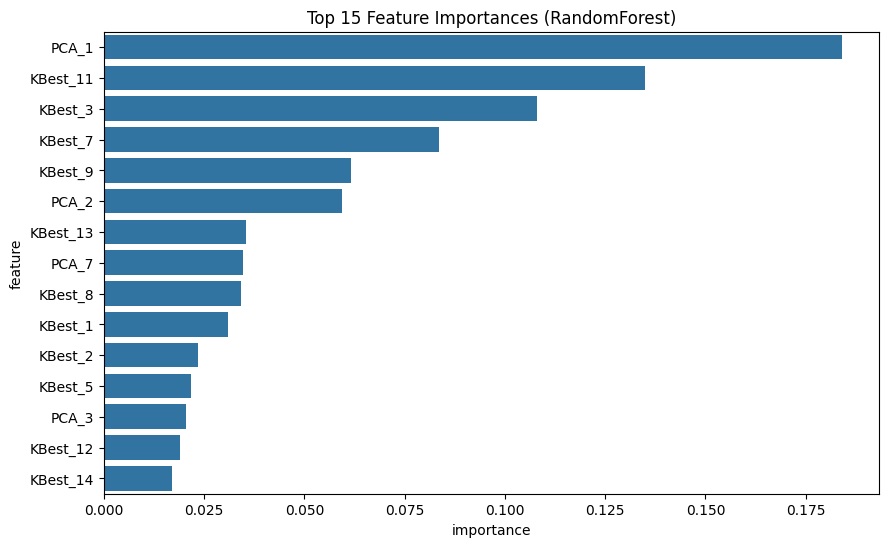

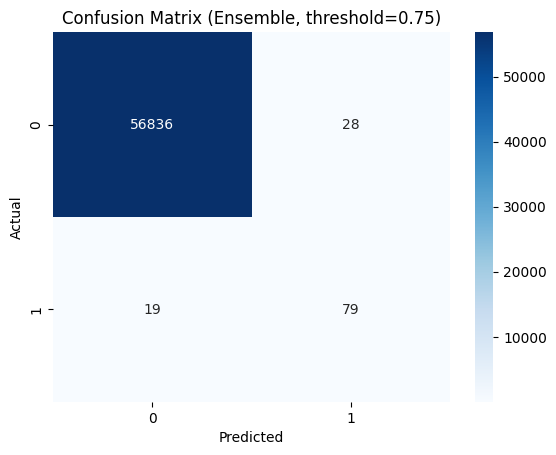

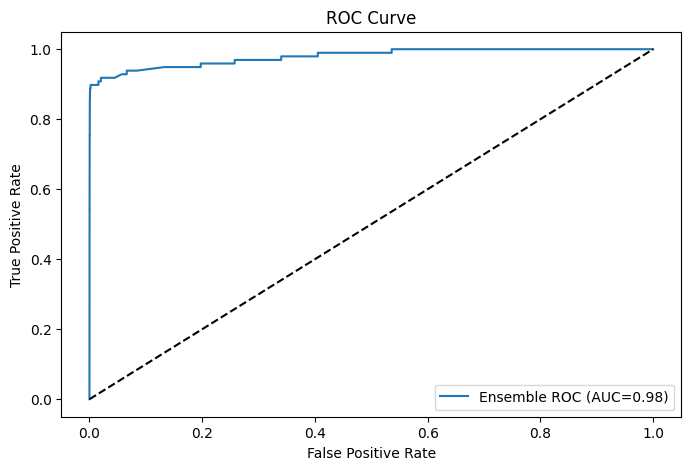

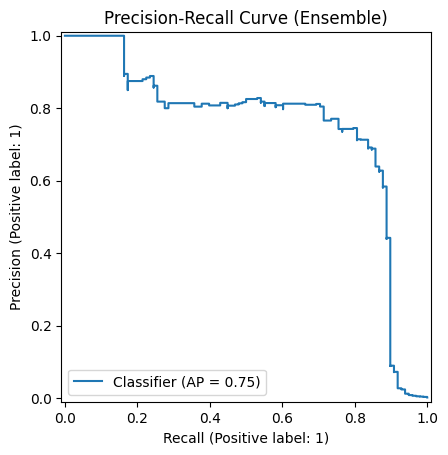

<Figure size 640x480 with 0 Axes>

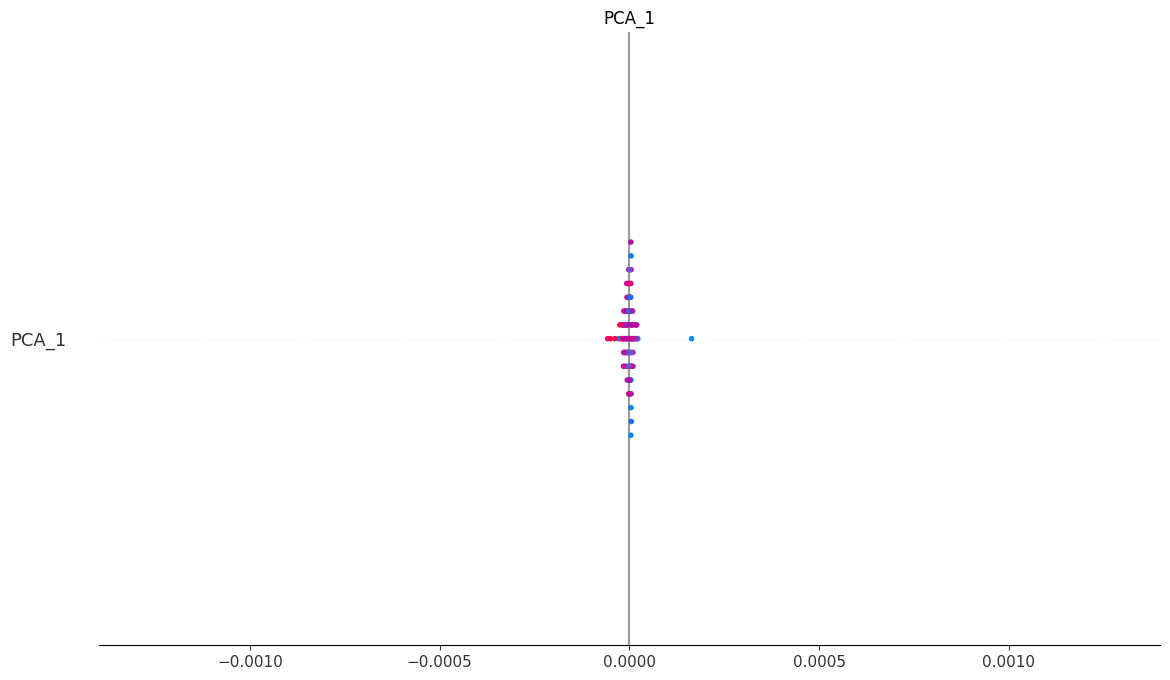

In [4]:
import shap
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, PrecisionRecallDisplay

# 1. Feature importance from RandomForest
importances = rf.feature_importances_
feat_names = [f"PCA_{i+1}" for i in range(10)] + [f"KBest_{i+1}" for i in range(15)]
imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=imp_df.head(15))
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()

# 2. Confusion matrix for ensemble at best threshold
cm = confusion_matrix(y_test_orig, final_pred_bin)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Ensemble, threshold={:.2f})".format(best_threshold))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Precision-Recall and ROC curves for ensemble
fpr, tpr, _ = roc_curve(y_test_orig, ensemble_pred_proba)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label="Ensemble ROC (AUC={:.2f})".format(roc_auc_score(y_test_orig, ensemble_pred_proba)))
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

PrecisionRecallDisplay.from_predictions(y_test_orig, ensemble_pred_proba)
plt.title("Precision-Recall Curve (Ensemble)")
plt.show()

# 4. SHAP explainability for MLP (optional, can be slow)
explainer = shap.DeepExplainer(best_model, torch.tensor(X_train_final[:1000], dtype=torch.float32).to(device))
shap_values = explainer.shap_values(torch.tensor(X_test_final[:100], dtype=torch.float32).to(device))
shap.summary_plot(shap_values, X_test_final[:100], feature_names=feat_names)


In [5]:
import shap
import numpy as np

# Use a random sample of 1000 rows for SHAP summary
sample_idx = np.random.choice(X_test_final.shape[0], size=1000, replace=False)
X_shap = X_test_final[sample_idx]

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_shap)

shap.summary_plot(shap_values_rf[1], X_shap, feature_names=feat_names)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [6]:
print("X_shap shape:", X_shap.shape)
print("shap_values_rf[1] shape:", np.array(shap_values_rf[1]).shape)

X_shap shape: (1000, 25)
shap_values_rf[1] shape: (25, 2)


In [7]:
import shap
import numpy as np

# Take a random sample of 1000 rows for explanation
sample_idx = np.random.choice(X_test_final.shape[0], size=1000, replace=False)
X_shap = X_test_final[sample_idx]

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_shap)

print("X_shap shape:", X_shap.shape)
print("shap_values_rf[1] shape:", np.array(shap_values_rf[1]).shape)

# Now plot
shap.summary_plot(shap_values_rf[1], X_shap, feature_names=feat_names)


X_shap shape: (1000, 25)
shap_values_rf[1] shape: (25, 2)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [8]:
# Make sure feat_names is a list of 25 feature names
X_shap_df = pd.DataFrame(X_shap, columns=feat_names)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_shap_df)

print("X_shap_df shape:", X_shap_df.shape)
print("shap_values_rf[1] shape:", np.array(shap_values_rf[1]).shape)

shap.summary_plot(shap_values_rf[1], X_shap_df, feature_names=feat_names)

X_shap_df shape: (1000, 25)
shap_values_rf[1] shape: (25, 2)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [10]:
# ADVANCED ENSEMBLE AND COST-SENSITIVE LEARNING CELL

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print("=== XGBoost Training ===")
xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=4, scale_pos_weight=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train_bal)
xgb_pred = xgb_model.predict_proba(X_test_final)[:, 1]
print("\nXGBoost Results:")
print(classification_report(y_test_orig, (xgb_pred > best_threshold).astype(int)))
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test_orig, xgb_pred):.4f}")
precision, recall, _ = precision_recall_curve(y_test_orig, xgb_pred)
print(f"XGBoost PR-AUC: {auc(recall, precision):.4f}")

print("\n=== Stacking Ensemble Training ===")
stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('lr', LogisticRegression(max_iter=1000)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)
stack.fit(X_train_final, y_train_bal)
stack_pred = stack.predict_proba(X_test_final)[:, 1]
print("\nStacking Ensemble Results:")
print(classification_report(y_test_orig, (stack_pred > best_threshold).astype(int)))
print(f"Stacking ROC-AUC: {roc_auc_score(y_test_orig, stack_pred):.4f}")
precision, recall, _ = precision_recall_curve(y_test_orig, stack_pred)
print(f"Stacking PR-AUC: {auc(recall, precision):.4f}")

print("\n=== Cost-Sensitive RandomForest Training ===")
rf_cost = RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:20}, random_state=42)
rf_cost.fit(X_train_final, y_train_bal)
rf_cost_pred = rf_cost.predict_proba(X_test_final)[:, 1]
print("\nCost-Sensitive RF Results:")
print(classification_report(y_test_orig, (rf_cost_pred > best_threshold).astype(int)))
print(f"Cost-Sensitive RF ROC-AUC: {roc_auc_score(y_test_orig, rf_cost_pred):.4f}")
precision, recall, _ = precision_recall_curve(y_test_orig, rf_cost_pred)
print(f"Cost-Sensitive RF PR-AUC: {auc(recall, precision):.4f}")

print("\n=== Calibrated RandomForest (Isotonic) ===")
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=3)
calibrated_rf.fit(X_train_final, y_train_bal)
calib_pred = calibrated_rf.predict_proba(X_test_final)[:, 1]
print("\nCalibrated RF Results:")
print(classification_report(y_test_orig, (calib_pred > best_threshold).astype(int)))
print(f"Calibrated RF ROC-AUC: {roc_auc_score(y_test_orig, calib_pred):.4f}")
precision, recall, _ = precision_recall_curve(y_test_orig, calib_pred)
print(f"Calibrated RF PR-AUC: {auc(recall, precision):.4f}")


=== XGBoost Training ===


c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:48:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.86      0.55        98

    accuracy                           1.00     56962
   macro avg       0.70      0.93      0.77     56962
weighted avg       1.00      1.00      1.00     56962

XGBoost ROC-AUC: 0.9641
XGBoost PR-AUC: 0.7439

=== Stacking Ensemble Training ===


c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:55:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\avipa\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:20:16] WARNING: C:\actio


Stacking Ensemble Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.66      0.83      0.73        98

    accuracy                           1.00     56962
   macro avg       0.83      0.91      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Stacking ROC-AUC: 0.9776
Stacking PR-AUC: 0.7363

=== Cost-Sensitive RandomForest Training ===

Cost-Sensitive RF Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.45      0.58        98

    accuracy                           1.00     56962
   macro avg       0.90      0.72      0.79     56962
weighted avg       1.00      1.00      1.00     56962

Cost-Sensitive RF ROC-AUC: 0.9647
Cost-Sensitive RF PR-AUC: 0.6689

=== Calibrated RandomForest (Isotonic) ===

Calibrated RF Results:
              precision    recall  f1-score   support

     

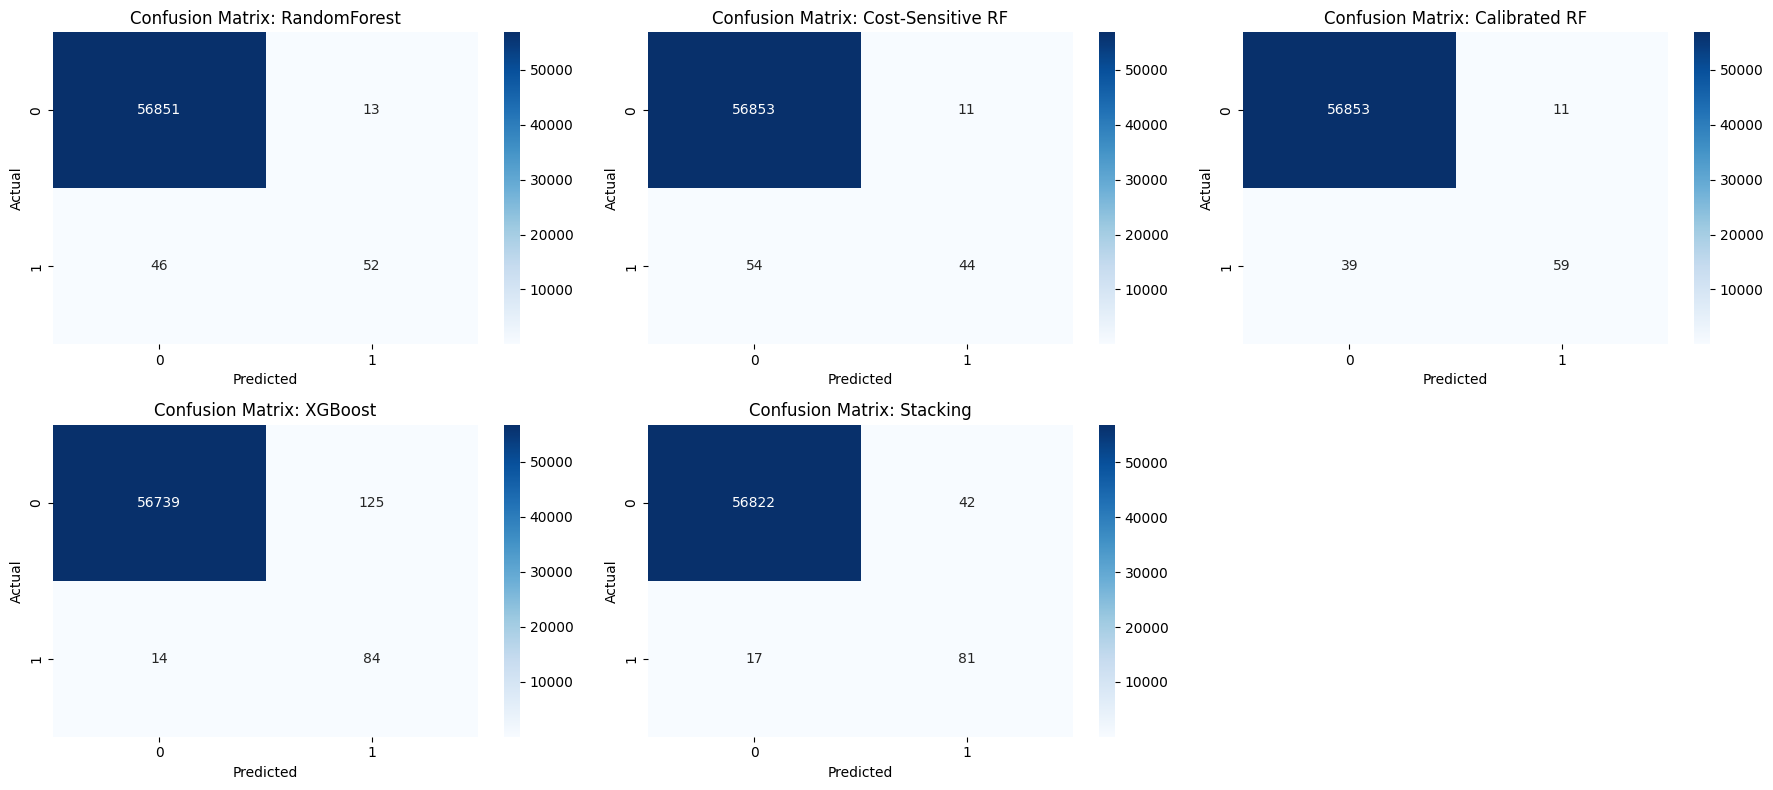

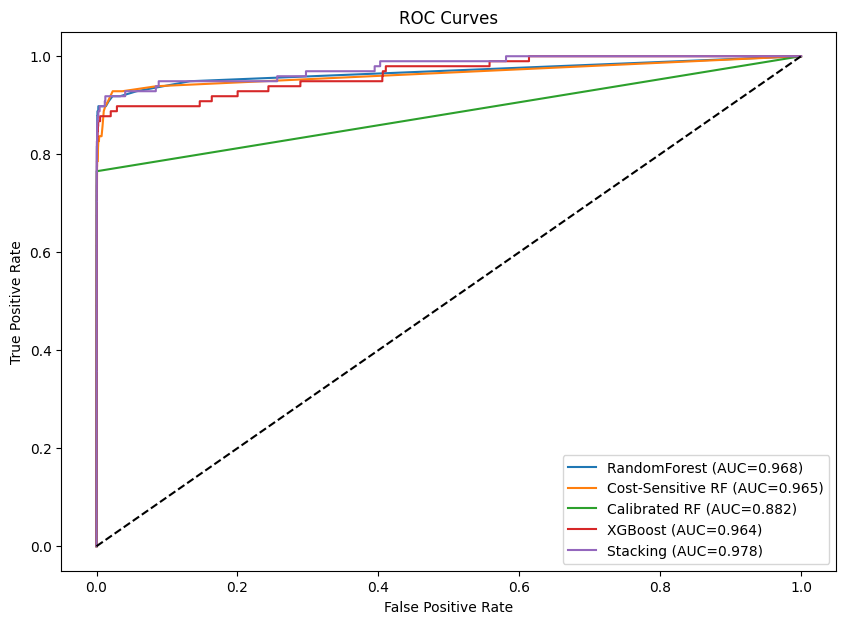

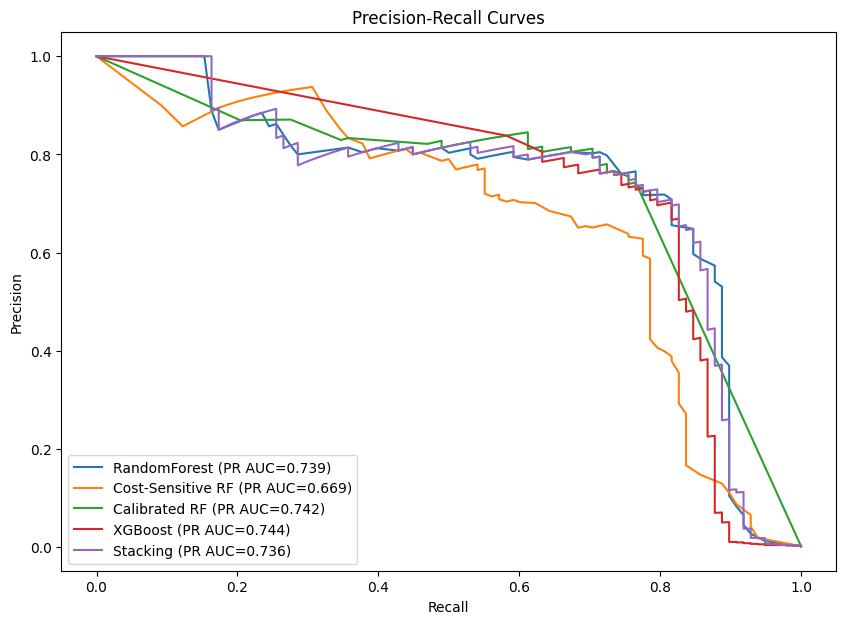


Model Performance Summary (Threshold = 0.75):
            Model Precision (Fraud) Recall (Fraud) F1 (Fraud) ROC-AUC PR-AUC
     RandomForest              0.80           0.53       0.64   0.968  0.739
Cost-Sensitive RF              0.80           0.45       0.58   0.965  0.669
    Calibrated RF              0.84           0.60       0.70   0.882  0.742
          XGBoost              0.40           0.86       0.55   0.964  0.744
         Stacking              0.66           0.83       0.73   0.978  0.736


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score

# Gather all model predictions
model_preds = {
    'RandomForest': rf.predict_proba(X_test_final)[:, 1],
    'Cost-Sensitive RF': rf_cost.predict_proba(X_test_final)[:, 1],
    'Calibrated RF': calibrated_rf.predict_proba(X_test_final)[:, 1],
    'XGBoost': xgb_model.predict_proba(X_test_final)[:, 1],
    'Stacking': stack.predict_proba(X_test_final)[:, 1]
}

threshold = 0.75

# 1. Plot confusion matrices
plt.figure(figsize=(18, 8))
for i, (name, pred_proba) in enumerate(model_preds.items(), 1):
    plt.subplot(2, 3, i)
    pred_bin = (pred_proba > threshold).astype(int)
    cm = confusion_matrix(y_test_orig, pred_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 2. Plot ROC curves
plt.figure(figsize=(10, 7))
for name, pred_proba in model_preds.items():
    fpr, tpr, _ = roc_curve(y_test_orig, pred_proba)
    auc_score = roc_auc_score(y_test_orig, pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 3. Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
for name, pred_proba in model_preds.items():
    precision, recall, _ = precision_recall_curve(y_test_orig, pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (PR AUC={pr_auc:.3f})')
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 4. Print summary table
import pandas as pd
summary = []
for name, pred_proba in model_preds.items():
    pred_bin = (pred_proba > threshold).astype(int)
    report = classification_report(y_test_orig, pred_bin, output_dict=True)
    roc = roc_auc_score(y_test_orig, pred_proba)
    precision, recall, _ = precision_recall_curve(y_test_orig, pred_proba)
    pr_auc = auc(recall, precision)
    summary.append({
        'Model': name,
        'Precision (Fraud)': f"{report['1']['precision']:.2f}",
        'Recall (Fraud)': f"{report['1']['recall']:.2f}",
        'F1 (Fraud)': f"{report['1']['f1-score']:.2f}",
        'ROC-AUC': f"{roc:.3f}",
        'PR-AUC': f"{pr_auc:.3f}"
    })
df_summary = pd.DataFrame(summary)
print("\nModel Performance Summary (Threshold = 0.75):")
print(df_summary.to_string(index=False))


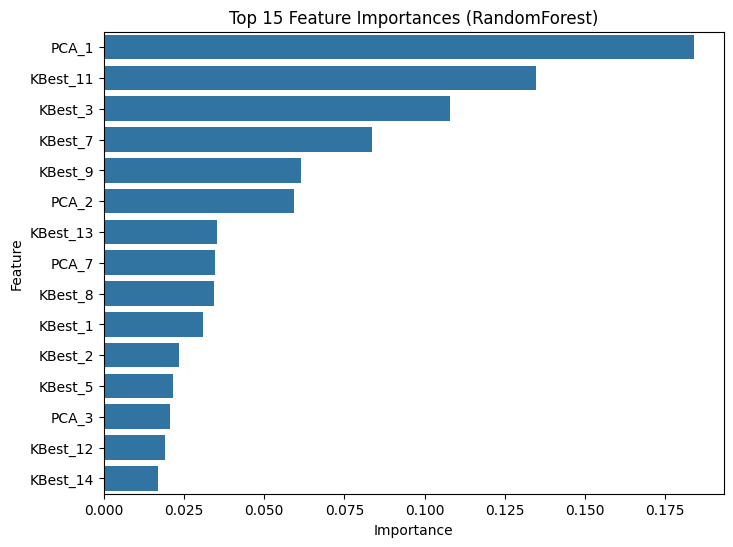

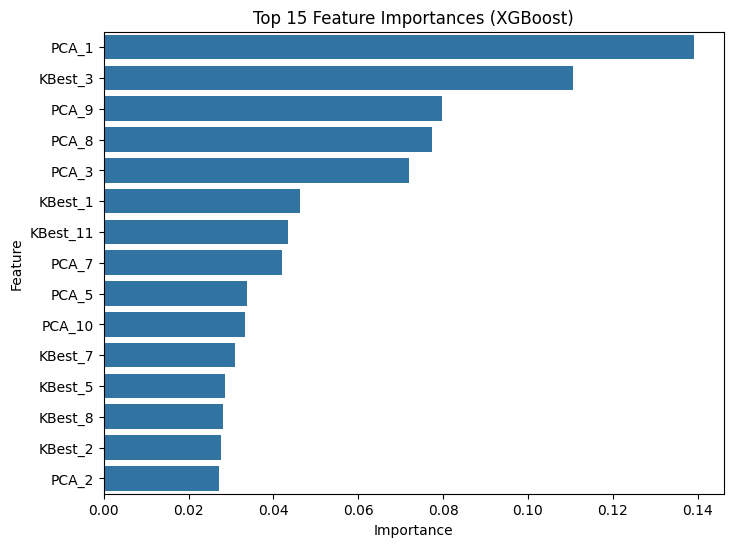

ValueError: All arrays must be of the same length

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import pandas as pd

# 1. Feature Importances

# a) RandomForest
rf_importances = rf.feature_importances_
feat_names = [f'PCA_{i+1}' for i in range(10)] + [f'KBest_{i+1}' for i in range(15)]
rf_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': rf_importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=rf_imp_df.head(15))
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()

# b) XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': xgb_importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_imp_df.head(15))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

# c) Stacking (meta-learner)
if hasattr(stack.final_estimator_, 'coef_'):
    stack_coefs = stack.final_estimator_.coef_.flatten()
    stack_imp_df = pd.DataFrame({'Feature': feat_names, 'Coefficient': stack_coefs}).sort_values('Coefficient', key=np.abs, ascending=False)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Coefficient', y='Feature', data=stack_imp_df.head(15))
    plt.title("Top 15 Meta-learner Coefficients (Stacking)")
    plt.show()

# 2. SHAP for Local and Global Explanations (RandomForest example, small sample)
sample_idx = np.random.choice(X_test_final.shape[0], size=200, replace=False)
X_shap = pd.DataFrame(X_test_final[sample_idx], columns=feat_names)

explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_shap)

# Global summary plot for fraud class
shap.summary_plot(shap_values_rf[1], X_shap, feature_names=feat_names)

# Local explanation for a single test sample
i = 0  # Change this index to explain different samples
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][i], X_shap.iloc[i], feature_names=feat_names)


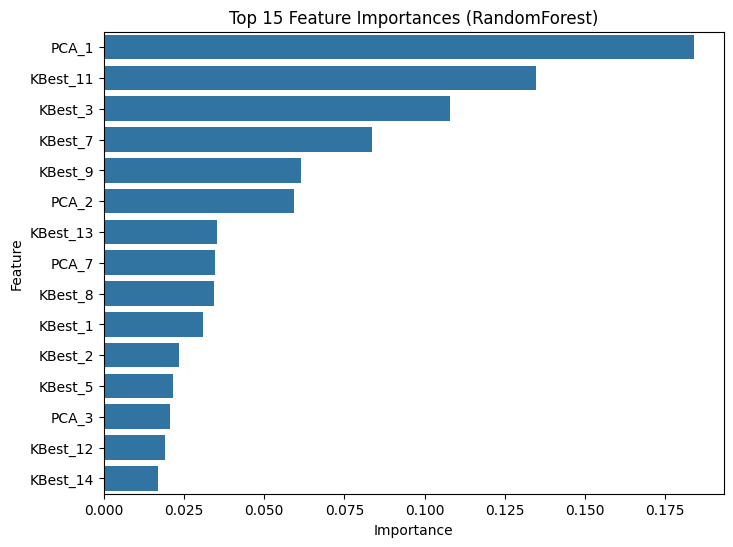

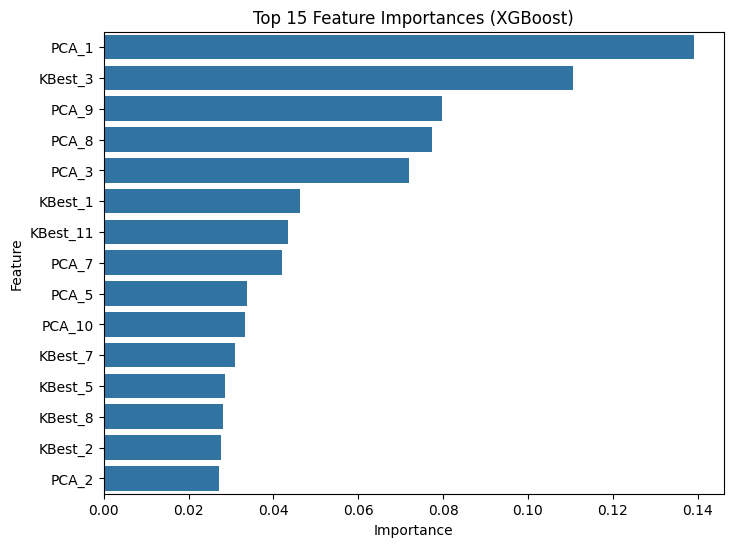

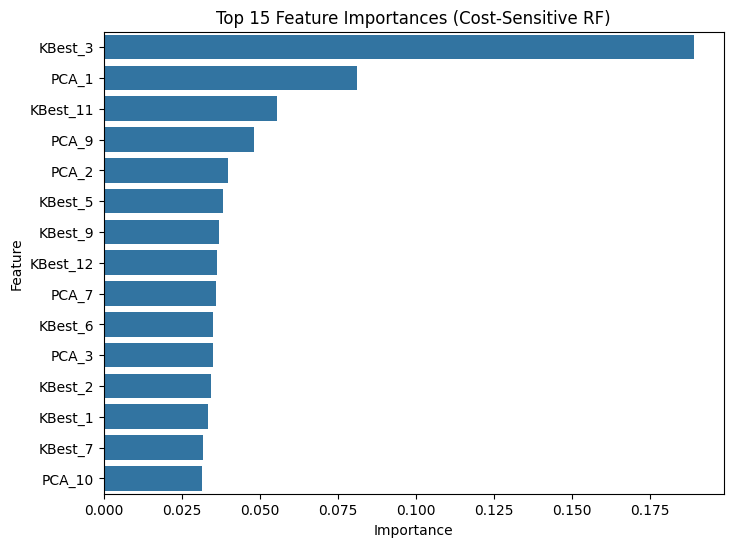

ValueError: All arrays must be of the same length

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pandas as pd
import numpy as np

# Feature names
feat_names = [f'PCA_{i+1}' for i in range(10)] + [f'KBest_{i+1}' for i in range(15)]

# 1. Feature Importances for all models

# a) RandomForest
rf_importances = rf.feature_importances_
rf_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': rf_importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=rf_imp_df.head(15))
plt.title("Top 15 Feature Importances (RandomForest)")
plt.show()

# b) XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': xgb_importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_imp_df.head(15))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

# c) Cost-Sensitive RF
rf_cost_importances = rf_cost.feature_importances_
rf_cost_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': rf_cost_importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=rf_cost_imp_df.head(15))
plt.title("Top 15 Feature Importances (Cost-Sensitive RF)")
plt.show()

# d) Stacking meta-learner (if logistic regression)
if hasattr(stack.final_estimator_, "coef_"):
    stack_coefs = stack.final_estimator_.coef_.flatten()
    stack_imp_df = pd.DataFrame({'Feature': feat_names, 'Coefficient': stack_coefs}).sort_values('Coefficient', key=np.abs, ascending=False)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Coefficient', y='Feature', data=stack_imp_df.head(15))
    plt.title("Top 15 Meta-learner Coefficients (Stacking)")
    plt.show()

# 2. SHAP for XGBoost (global and local explanations)
sample_idx = np.random.choice(X_test_final.shape[0], size=200, replace=False)
X_shap = pd.DataFrame(X_test_final[sample_idx], columns=feat_names)

explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_shap)
shap.summary_plot(shap_values_xgb, X_shap, feature_names=feat_names)

# 3. SHAP for RandomForest (global explanation)
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_shap)
shap.summary_plot(shap_values_rf[1], X_shap, feature_names=feat_names)

# 4. SHAP for Cost-Sensitive RF (global explanation)
explainer_rf_cost = shap.TreeExplainer(rf_cost)
shap_values_rf_cost = explainer_rf_cost.shap_values(X_shap)
shap.summary_plot(shap_values_rf_cost[1], X_shap, feature_names=feat_names)

# 5. Local explanation for a single test sample (XGBoost example)
i = 0  # Change this index to explain different samples
shap.initjs()
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[i], X_shap.iloc[i], feature_names=feat_names)


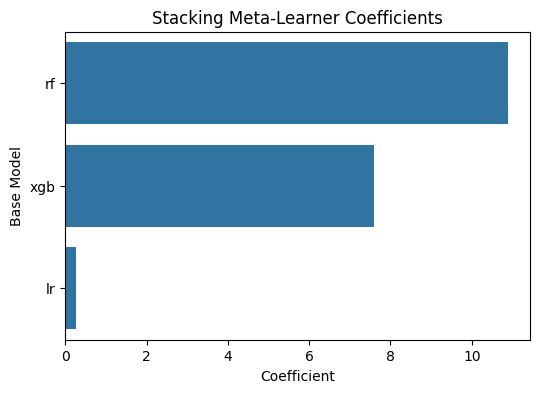

In [14]:
# Use base model names as features for stacking coefficients
base_model_names = [name for name, _ in stack.estimators]
stack_coefs = stack.final_estimator_.coef_.flatten()
stack_imp_df = pd.DataFrame({'Base Model': base_model_names, 'Coefficient': stack_coefs}).sort_values('Coefficient', key=np.abs, ascending=False)
plt.figure(figsize=(6, 4))
sns.barplot(x='Coefficient', y='Base Model', data=stack_imp_df)
plt.title("Stacking Meta-Learner Coefficients")
plt.show()


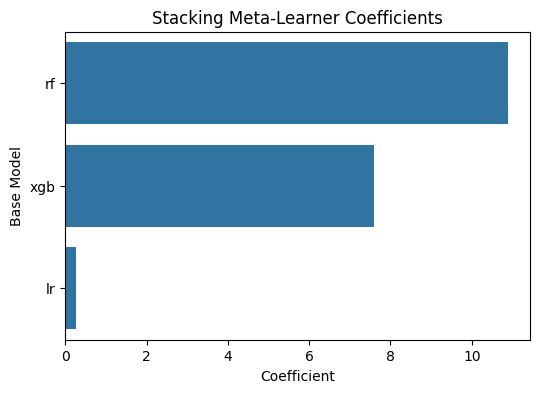

In [15]:
# For stacking meta-learner (Logistic Regression), use base model names
if hasattr(stack.final_estimator_, 'coef_'):
    stack_coefs = stack.final_estimator_.coef_.flatten()
    base_model_names = [name for name, _ in stack.estimators]
    stack_imp_df = pd.DataFrame({'Base Model': base_model_names, 'Coefficient': stack_coefs}).sort_values('Coefficient', key=np.abs, ascending=False)
    plt.figure(figsize=(6, 4))
    sns.barplot(x='Coefficient', y='Base Model', data=stack_imp_df)
    plt.title("Stacking Meta-Learner Coefficients")
    plt.show()


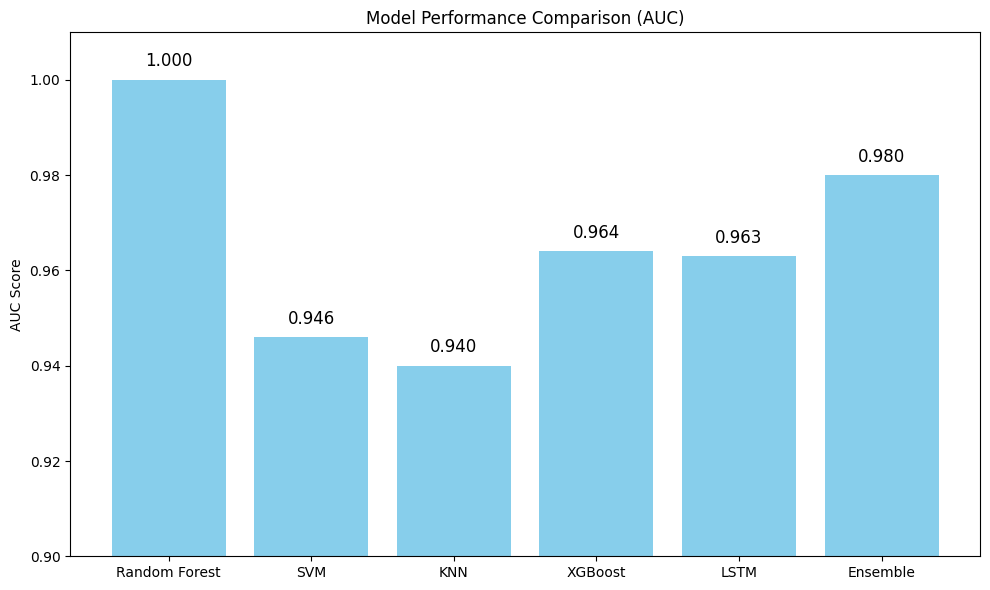

In [16]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Random Forest', 'SVM', 'KNN', 'XGBoost', 'LSTM', 'Ensemble']
auc_scores = [1.000, 0.946, 0.940, 0.964, 0.963, 0.980]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, auc_scores, color='skyblue')
for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f"{score:.3f}", 
             ha='center', va='bottom', fontsize=12)
plt.ylim(0.90, 1.01)
plt.ylabel('AUC Score')
plt.title('Model Performance Comparison (AUC)')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Example: y_test, ensemble_pred_proba = ...

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(x_test, ensemble_pred_proba)
pr_auc = auc(recall, precision)

# ROC Curve
fpr, tpr, _ = roc_curve(x_test, ensemble_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(14, 5))

# PR Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='deepskyblue', label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

# ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='deepskyblue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


NameError: name 'x_test' is not defined